# P4

## Exploratory Data Analysis

In [1]:
# %matplotlib widget

import pandas as pd
import pandasql as psql
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
geolocation = pd.read_csv('dataset/olist_geolocation_dataset.csv')
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
order_payments = pd.read_csv('dataset/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
products = pd.read_csv('dataset/olist_products_dataset.csv')
sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
product_category_name = pd.read_csv('dataset/product_category_name_translation.csv')



### Locations

In [3]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [4]:
geolocation = geolocation.groupby('geolocation_city')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
geolocation.set_index('geolocation_city')

,geolocation_lat,geolocation_lng
geolocation_city,,
* cidade,-25.571748,-49.334374
...arraial do cabo,-22.969370,-42.029834
4o. centenario,-24.271860,-53.069433
4º centenario,-24.279801,-53.074723
abadia de goias,-16.767063,-49.438089
...,...,...
áurea,-27.695009,-52.055076
ângulo,-23.195024,-51.917294
érico cardoso,-13.393047,-42.134282


In [5]:
# pipo, citya_lat, citya_lng = list(zip(geolocation[geolocation.geolocation_city == 'abare']))
city_coord = geolocation[geolocation.geolocation_city == 'abare'].to_numpy()
city_coord[0][1]
# citya_lat = citya_coord['geolocation_lat']
# citya_lng = citya_coord['geolocation_lng']
# citya_lat


-8.689967452179038

In [6]:
from haversine import haversine, Unit

olist_hq_loc = (-25.430296283573938, -49.29199547244041) # olist head quarter position

def position(row):
    return haversine(olist_hq_loc, (row['geolocation_lat'], row['geolocation_lng']), unit=Unit.KILOMETERS)

def distance_btw_cities(citya, cityb):
    citya_coord = geolocation[geolocation.geolocation_city == citya].to_numpy()
    # print(citya_coord)
    cityb_coord = geolocation[geolocation.geolocation_city == cityb].to_numpy()
    # print(cityb_coord)
    return haversine((citya_coord[0][1], citya_coord[0][2]), (cityb_coord[0][1], cityb_coord[0][2]))

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return np.around(km, 0)



In [7]:
distance_btw_cities('abare', 'abrantes')

470.724756693975

### Customers


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
# use customer_unique_id for joining

print(customers['customer_unique_id'].nunique())
print(customers['customer_id'].nunique())

# customers = customers.merge(geolocation, left_on='customer_city', right_on='geolocation_city', how='left')
customers.drop('customer_zip_code_prefix', axis=1, inplace=True)
customers.drop('customer_state', axis=1, inplace=True)
# customers.drop('geolocation_city', axis=1, inplace=True)


96096
99441


### Products

In [10]:
#  join on product_id
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [11]:
products['product_category_name'].nunique()

73

In [12]:
products.drop('product_name_lenght', axis=1, inplace=True)
products.drop('product_description_lenght', axis=1, inplace=True)
products.drop('product_photos_qty', axis=1, inplace=True)
products['product_volume'] = products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']
products.drop('product_length_cm', axis=1, inplace=True)
products.drop('product_height_cm', axis=1, inplace=True)
products.drop('product_width_cm', axis=1, inplace=True)

### Order Items

In [13]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
order_items.groupby(['seller_id'])\
    .agg({'product_id': 'count', 'price': 'sum'})\
    .reset_index()\
    .sort_values(by=['product_id', 'price'], ascending=False)\
    .rename(columns={'product_id' : 'product_id_count', 'price': 'price_sum'})

,seller_id,product_id_count,price_sum
1235,6560211a19b47992c3666cc44a7e94c0,2033,123304.83
881,4a3ca9315b744ce9f8e9374361493884,1987,200472.92
368,1f50f920176fa81dab994f9023523100,1931,106939.21
2481,cc419e0650a3c5ba77189a1882b7556a,1775,104288.42
2643,da8622b14eb17ae2831f4ac5b9dab84a,1551,160236.57
...,...,...,...
627,34aefe746cd81b7f3b23253ea28bef39,1,8.00
1370,702835e4b785b67a084280efca355756,1,7.60
373,1fa2d3def6adfa70e58c276bb64fe5bb,1,6.90
1465,77128dec4bec4878c37ab7d6169d6f26,1,6.50


In [15]:
# several sellers may exists for one single order (providing several products)
order_items.groupby(['order_id'])\
    .agg({'seller_id': 'nunique'})\
    .sort_values(by='seller_id', ascending=False)
    

,seller_id
order_id,
1c11d0f4353b31ac3417fbfa5f0f2a8a,5
cf5c8d9f52807cb2d2f0a0ff54c478da,5
8c2b13adf3f377c8f2b06b04321b0925,4
91be51c856a90d7efe86cf9d082d6ae3,4
1d23106803c48c391366ff224513fb7f,4
...,...
55e186387dc4b33d16d86a920ee7f77b,1
55e144afb3e4115f6c520fb6242cd1bf,1
55dfff244bc5d5f81d58d4148062c9b6,1


In [16]:
#  some orders have several products, so compute the overal sum for each order
order_items_grouped = order_items.groupby(['order_id'])\
    .agg({'product_id': 'count', 'price': 'sum', 'seller_id' : 'count'})\
    .reset_index()\
    .sort_values(by=['product_id', 'price'], ascending=False)\
    .rename(columns={'product_id' : 'product_id_count', 'price': 'price_sum'})

order_items_grouped


,order_id,product_id_count,price_sum,seller_id
50137,8272b63d03f5f79c56e9e4120aec44ef,21,31.80,21
10459,1b15974a0141d54e36626dca3fdc731a,20,2000.00,20
65715,ab14fdcfbe524636d65ee38360e22ce8,20,1974.00,20
25583,428a2f660dc84138d969ccd69a0ab6d5,15,982.35,15
60941,9ef13efd6949e4573a18964dd1bbe7f5,15,765.00,15
...,...,...,...,...
21805,38bcb524e1c38c2c1b60600a80fc8999,1,2.90,1
89758,e8bbc1d69fee39eee4c72cb5c969e39d,1,2.29,1
93208,f1d5c2e6867fa93ceee9ef9b34a53cbf,1,2.20,1
24174,3ee6513ae7ea23bdfab5b9ab60bffcb5,1,0.85,1


### Order Payments

In [17]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [18]:
print(order_payments['order_id'].nunique())
print(order_payments['payment_installments'].nunique())
print(order_payments.shape[0])

# installments = versements, join on order_id
order_payments = order_payments.groupby('order_id')['payment_installments'].max().reset_index()

print(order_payments['order_id'].nunique())
print(order_payments['payment_installments'].nunique())
print(order_payments.shape[0])

99440
24
103886
99440
24
99440


### Order Review

In [19]:
#  just keep review_score, review_creation_date, join on order_id
order_reviews.info()
order_reviews.drop('review_id', axis=1, inplace=True)
order_reviews.drop('review_comment_title', axis=1, inplace=True)
order_reviews.drop('review_comment_message', axis=1, inplace=True)
order_reviews.drop('review_answer_timestamp', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


### Orders

In [20]:
#  join on order_id
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [21]:
orders.drop('order_status', axis=1, inplace=True)
# orders.drop('customer_id', axis=1, inplace=True)
# print(orders['customer_id'].nunique())
print(orders.shape[0])

99441


### Sellers

In [22]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [23]:
sellers.drop(['seller_state', 'seller_zip_code_prefix'], axis=1, inplace=True)

## Merge datasets

In [24]:
olist = customers.merge(orders, on='customer_id', how='left')
olist = olist.merge(order_items, on='order_id', how='outer')
olist = olist.merge(order_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(sellers, on='seller_id', how='outer')

olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    114092 non-null  object 
 1   customer_unique_id             114092 non-null  object 
 2   customer_city                  114092 non-null  object 
 3   order_id                       114092 non-null  object 
 4   order_purchase_timestamp       114092 non-null  object 
 5   order_approved_at              113930 non-null  object 
 6   order_delivered_carrier_date   112112 non-null  object 
 7   order_delivered_customer_date  110839 non-null  object 
 8   order_estimated_delivery_date  114092 non-null  object 
 9   order_item_id                  113314 non-null  float64
 10  product_id                     113314 non-null  object 
 11  seller_id                      113314 non-null  object 
 12  shipping_limit_date           

In [25]:
olist['order_delivered_carrier_date'] = pd.to_datetime(olist['order_delivered_carrier_date'])
olist['order_delivered_customer_date'] = pd.to_datetime(olist['order_delivered_customer_date'])
olist['order_estimated_delivery_date'] = pd.to_datetime(olist['order_estimated_delivery_date'])
olist['shipping_limit_date'] = pd.to_datetime(olist['shipping_limit_date'])
olist['review_creation_date'] = pd.to_datetime(olist['review_creation_date'])
olist['order_purchase_timestamp'] = pd.to_datetime(olist['order_purchase_timestamp'])
olist['order_approved_at'] = pd.to_datetime(olist['order_approved_at'])

In [26]:

olist.drop(['customer_id', 'order_id', 'order_item_id', 'product_id', 'seller_id'], axis=1, inplace=True)
olist.dropna(inplace=True)

olist.head()

,customer_unique_id,customer_city,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,review_score,review_creation_date,product_category_name,product_weight_g,product_volume,seller_city
0,861eff4711a542e4b93843c6dd7febb0,franca,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-22 15:22:12,124.99,21.88,4.0,2017-05-26,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,2017-11-23 00:47:18,112.99,24.90,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
2,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,2017-11-23 00:47:18,112.99,24.90,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
3,3c799d181c34d51f6d44bbbc563024db,nova santa rita,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12,2017-05-22 22:22:56,124.99,15.62,3.0,2017-05-27,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
4,23397e992b09769faf5e66f9e171a241,mage,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22,2018-02-18 21:29:19,106.99,30.59,4.0,2018-03-01,moveis_escritorio,8683.0,107136.0,itaquaquecetuba


<AxesSubplot:ylabel='None'>

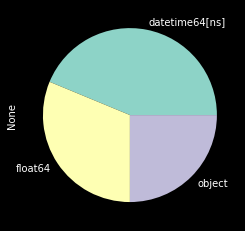

In [27]:
olist.dtypes.value_counts().plot.pie()

In [28]:
olist.select_dtypes("float")

,price,freight_value,review_score,product_weight_g,product_volume
0,124.99,21.88,4.0,8683.0,107136.0
1,112.99,24.90,1.0,8683.0,107136.0
2,112.99,24.90,1.0,8683.0,107136.0
3,124.99,15.62,3.0,8683.0,107136.0
4,106.99,30.59,4.0,8683.0,107136.0
...,...,...,...,...,...
114085,1750.00,39.02,4.0,1100.0,3000.0
114086,145.90,15.47,5.0,2250.0,7168.0
114088,49.90,22.28,5.0,200.0,8960.0
114090,135.98,88.46,5.0,3211.0,41976.0


In [29]:
olist.select_dtypes("object")

,customer_unique_id,customer_city,product_category_name,seller_city
0,861eff4711a542e4b93843c6dd7febb0,franca,moveis_escritorio,itaquaquecetuba
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,moveis_escritorio,itaquaquecetuba
2,9eae34bbd3a474ec5d07949ca7de67c0,santarem,moveis_escritorio,itaquaquecetuba
3,3c799d181c34d51f6d44bbbc563024db,nova santa rita,moveis_escritorio,itaquaquecetuba
4,23397e992b09769faf5e66f9e171a241,mage,moveis_escritorio,itaquaquecetuba
...,...,...,...,...
114085,38e482d7770a43f5929378c4dec76d5e,parnamirim,beleza_saude,niteroi
114086,393c2ace23a135d0bcc7e70167448e16,barreiras,bebidas,salvador
114088,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,pet_shop,maringa
114090,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,ferramentas_jardim,sao jose dos pinhais


In [30]:
olist.select_dtypes("datetime")

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,review_creation_date
0,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-22 15:22:12,2017-05-26
1,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,2017-11-23 00:47:18,2017-11-29
2,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,2017-11-23 00:47:18,2017-11-29
3,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12,2017-05-22 22:22:56,2017-05-27
4,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22,2018-02-18 21:29:19,2018-03-01
...,...,...,...,...,...,...,...
114085,2018-08-16 15:02:31,2018-08-17 15:09:48,2018-08-20 13:22:00,2018-08-28 22:08:29,2018-09-24,2018-08-23 15:09:48,2018-08-29
114086,2018-07-20 09:42:40,2018-07-20 15:05:22,2018-07-23 11:53:00,2018-07-27 11:54:15,2018-08-14,2018-08-01 15:05:22,2018-07-28
114088,2018-08-01 18:58:49,2018-08-02 18:50:15,2018-08-03 15:39:00,2018-08-13 23:16:46,2018-08-27,2018-08-08 18:50:15,2018-08-14
114090,2018-08-18 20:59:58,2018-08-18 21:10:13,2018-08-20 16:49:00,2018-08-28 18:16:44,2018-09-10,2018-08-21 21:10:13,2018-08-29


In [31]:
olist.select_dtypes("int")

""
0
1
2
3
4
...
114085
114086
114088
114090


In [32]:
olist.select_dtypes("timedelta")

""
0
1
2
3
4
...
114085
114086
114088
114090


In [33]:
olist.select_dtypes("category")

""
0
1
2
3
4
...
114085
114086
114088
114090


In [34]:
# returning customers (more than one order or product), mean percentage
print(f"{((olist['customer_unique_id'].shape[0]) / (olist['customer_unique_id'].nunique()) -1)*100} %")


18.55823359020605 %


### Univariate & Multivariate Analysis

In [35]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]


<AxesSubplot:>

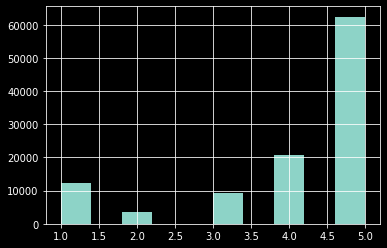

In [36]:
olist['review_score'].hist()

<AxesSubplot:>

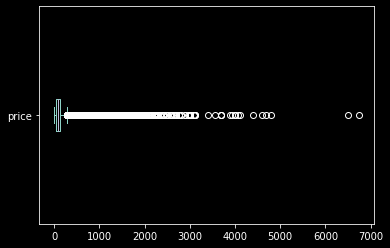

In [37]:
olist['price'].plot.box(vert=False)

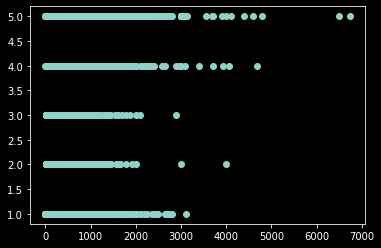

In [38]:
plt.scatter(olist['price'], olist['review_score'])

In [39]:
olist_bak = olist.copy()

## Features Engineering & Cleaning

In [40]:
olist.columns

Index(['customer_unique_id', 'customer_city', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'price', 'freight_value', 'review_score',
       'review_creation_date', 'product_category_name', 'product_weight_g',
       'product_volume', 'seller_city'],
      dtype='object')

### Product Size and Weight 

In [41]:
#  product size category
slices = ['0', '1', '2', '3', '4', '5']

c, bins = pd.qcut(olist['product_volume'], len(slices), labels=slices, retbins=True)
olist['product_volume']=c.values

c, bins = pd.qcut(olist['product_weight_g'], len(slices), labels=slices, retbins=True)
olist['product_weight'] = c.values

In [42]:
olist.drop('product_weight_g', axis=1, inplace=True)

<AxesSubplot:xlabel='product_volume'>

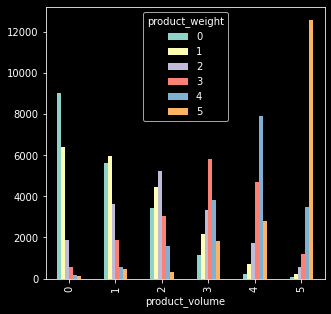

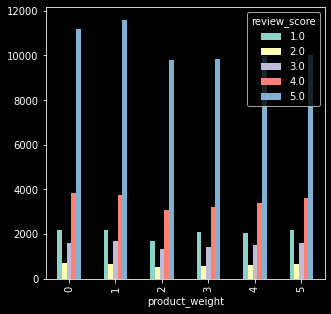

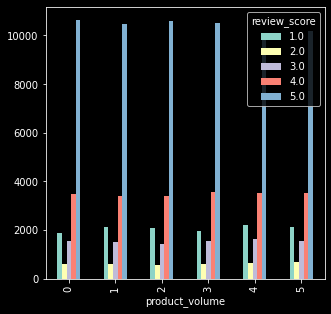

In [43]:

pd.crosstab(olist['product_volume'], olist['product_weight']).plot(kind='bar', stacked=False, figsize=(5,5))
pd.crosstab(olist['product_weight'], olist['review_score']).plot(kind='bar', stacked=False, figsize=(5,5))
pd.crosstab(olist['product_volume'], olist['review_score']).plot(kind='bar', stacked=False, figsize=(5,5))

### Order timestamps & delays

In [44]:
olist['payment_approval_delay'] = (olist['order_approved_at'] - olist['order_purchase_timestamp']).dt.days
olist['carrier_shipping_delay'] = (olist['order_delivered_customer_date'] - olist['order_delivered_carrier_date']).dt.days
olist['delivery_estimation_precision'] = (olist['order_delivered_customer_date'] - olist['order_estimated_delivery_date']).dt.days
# olist['delivery_total_delay'] =( olist['order_delivered_customer_date'] - olist['order_purchase_timestamp']).dt.days
olist['review_delay_after_delivery'] = (olist['review_creation_date'] - olist['order_delivered_customer_date']).dt.days
olist['review_delay_after_purchase'] = (olist['review_creation_date'] - olist['order_purchase_timestamp']).dt.days
olist['review_made_before_delivery'] = olist['review_creation_date'].lt(olist['order_delivered_customer_date'])



In [45]:

olist.drop('order_approved_at', axis=1, inplace=True)
olist.drop('order_purchase_timestamp', axis=1, inplace=True)
olist.drop('order_delivered_customer_date', axis=1, inplace=True)
olist.drop('order_delivered_carrier_date', axis=1, inplace=True)
olist.drop('order_estimated_delivery_date', axis=1, inplace=True)
olist.drop('review_creation_date', axis=1, inplace=True)
olist.drop('shipping_limit_date', axis=1, inplace=True)	  # don't need this one
# olist.drop('review_answer_timestamp', axis=1, inplace=True)	  # don't need this one ?? TODO check


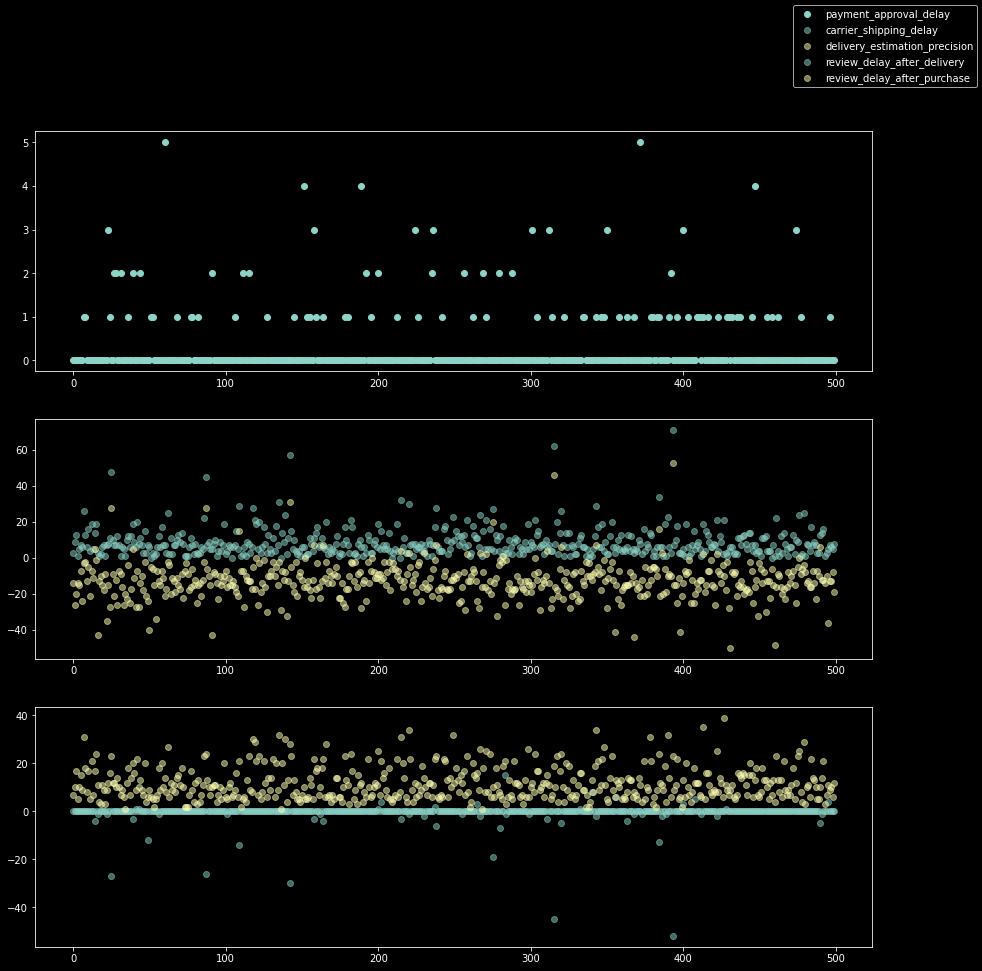

In [46]:
fig, ax = plt.subplots(3,1, figsize=(15,15))
size = 500
olist_light = olist.sample(size, random_state=1)
index = np.arange(0,size,1)
ax[0].scatter(index,olist_light['payment_approval_delay'], label='payment_approval_delay')
ax[1].scatter(index,olist_light['carrier_shipping_delay'], label='carrier_shipping_delay', alpha=0.5)
ax[1].scatter(index,olist_light['delivery_estimation_precision'], label='delivery_estimation_precision', alpha=0.5)
# ax[1].scatter(index,olist_light['delivery_total_delay'], label='delivery_total_delay', alpha=0.5)
ax[2].scatter(index,olist_light['review_delay_after_delivery'], label='review_delay_after_delivery', alpha=0.5)
ax[2].scatter(index,olist_light['review_delay_after_purchase'], label='review_delay_after_purchase', alpha=0.5)
fig.legend()

### Customers

In [47]:
# get review score and price grouped by customer_Id (only one customer per order)
customer_basket = olist.groupby('customer_unique_id')[['price', 'review_score']]\
    .agg(['count', 'sum', 'mean'])\
    .sort_values(by=('price', 'count'), ascending=False)
print(customer_basket[('review_score','mean')].mean())
customer_basket

4.154445508733917


price                      review_score  \
                                 count      sum        mean        count   
customer_unique_id                                                         
d97b3cfb22b0d6b25ac9ed4e9c2d481b    24  1593.16   66.381667           24   
c8460e4251689ba205045f3ea17884a1    24  4080.00  170.000000           24   
4546caea018ad8c692964e3382debd19    21    31.80    1.514286           21   
c402f431464c72e27330a67f7b94d4fb    20  2000.00  100.000000           20   
0f5ac8d5c31de21d2f25e24be15bbffb    18  1252.35   69.575000           18   
...                                ...      ...         ...          ...   
5a67f586c461ff4fe70143d4938bc1a1     1   110.00  110.000000            1   
5a66e36a847a98dae73468778263cf81     1    75.66   75.660000            1   
5a6637b7f03edf22def5e269822d4326     1    19.90   19.900000            1   
5a64b3fb0a71caa68a2cc3ac67c3c6df     1    24.90   24.900000            1   
ffffd2657e2aad2907e67c3e9daecbeb     1    56.99   56.990000            1   

                                             
                                   sum mean  
customer_unique_id                           
d97b3cfb22b0d6b25ac9ed4e9c2d481b  24.0  1.0  
c8460e4251689ba205045f3ea17884a1  96.0  4.0  
4546caea018ad8c692964e3382debd19  21.0  1.0  
c402f431464c72e27330a67f7b94d4fb  20.0  1.0  
0f5ac8d5c31de21d2f25e24be15bbffb  90.0  5.0  
...                                ...  ...  
5a67f586c461ff4fe70143d4938bc1a1   4.0  4.0  
5a66e36a847a98dae73468778263cf81   5.0  5.0  
5a6637b7f03edf22def5e269822d4326   5.0  5.0  
5a64b3fb0a71caa68a2cc3ac67c3c6df   5.0  5.0  
ffffd2657e2aad2907e67c3e9daecbeb   5.0  5.0  

[91485 rows x 6 columns]

### Locations


In [48]:
print(olist['customer_city'].isin(geolocation['geolocation_city']).mean())
print(olist['seller_city'].isin(geolocation['geolocation_city']).mean())

0.9993822778274619
0.9857278518941943


In [49]:
# ensure cities coordinates are defined
olist = olist[olist['customer_city'].isin(geolocation['geolocation_city'])]
olist = olist[olist['seller_city'].isin(geolocation['geolocation_city'])]

In [50]:
olist['customer_lat'] = olist.customer_city.map(geolocation.set_index('geolocation_city')['geolocation_lat'])
olist['customer_lng'] = olist.customer_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])
olist['seller_lat'] = olist.seller_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])
olist['seller_lng'] = olist.seller_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])


olist['distance_btw_seller_customer'] = haversine_vectorize(olist['customer_lat'], olist['customer_lng'], olist['seller_lat'], olist['seller_lng'])

# slice the distances
slices = np.arange(20)
c, bins = pd.qcut(olist['distance_btw_seller_customer'], len(slices), labels=slices, retbins=True)
olist['distance_btw_seller_customer']=c.values


In [51]:

olist.drop(['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'customer_city', 'seller_city'], axis=1, inplace=True)


### Features Correlations


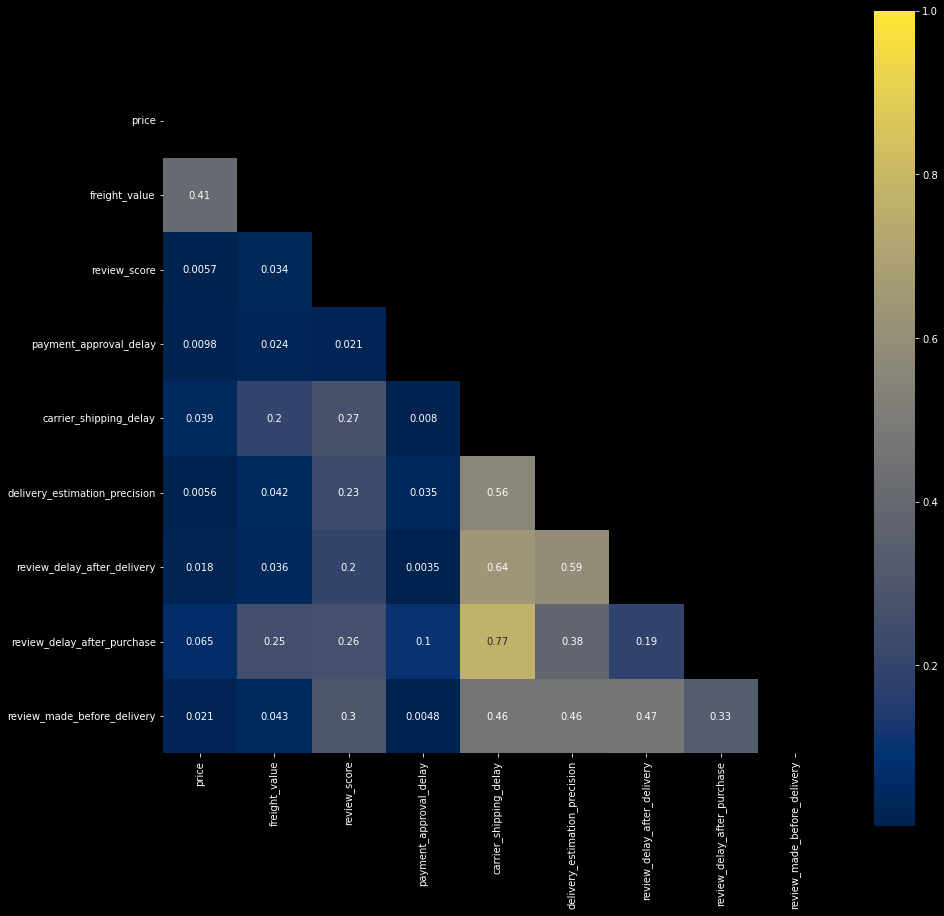

In [52]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes(['float', 'int', 'bool']).corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(15,15))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

show_feat_correlations(olist)

## Modelisation

### Preparation

In [53]:
olist.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 106853 entries, 0 to 114091
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_unique_id             106853 non-null  object  
 1   price                          106853 non-null  float64 
 2   freight_value                  106853 non-null  float64 
 3   review_score                   106853 non-null  float64 
 4   product_category_name          106853 non-null  object  
 5   product_volume                 106853 non-null  category
 6   product_weight                 106853 non-null  category
 7   payment_approval_delay         106853 non-null  int64   
 8   carrier_shipping_delay         106853 non-null  int64   
 9   delivery_estimation_precision  106853 non-null  int64   
 10  review_delay_after_delivery    106853 non-null  int64   
 11  review_delay_after_purchase    106853 non-null  int64   
 12  review_made_befo

In [54]:
# won't need anymore this feature
olist.drop('customer_unique_id', axis=1, inplace=True)

In [55]:
from sklearn import preprocessing

olist['product_category_name'] = preprocessing.LabelEncoder().fit_transform(olist['product_category_name'])


In [56]:
olist.head()

,price,freight_value,review_score,product_category_name,product_volume,product_weight,payment_approval_delay,carrier_shipping_delay,delivery_estimation_precision,review_delay_after_delivery,review_delay_after_purchase,review_made_before_delivery,distance_btw_seller_customer
0,124.99,21.88,4.0,55,5,5,0,1,-11,0,9,False,11
1,112.99,24.90,1.0,55,5,5,0,5,-21,0,19,False,18
2,112.99,24.90,1.0,55,5,5,0,5,-21,0,19,False,18
3,124.99,15.62,3.0,55,5,5,1,6,-17,0,19,False,0
4,106.99,30.59,4.0,55,5,5,1,9,-22,0,25,False,10


In [57]:
# ensure no empty values remains
assert olist[olist.isna().any(axis=1)].shape[0] == 0

### Raw KMeans 

In [96]:
from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score

size = 2000
olist_light = olist.head(size)

X = olist_light.drop('review_score', axis=1)
y = olist_light['review_score']

# olist_scaled = preprocessing.StandardScaler().fit_transform(X)
olist_scaled = preprocessing.MinMaxScaler().fit_transform(X)   #MinMax gives way better results !?


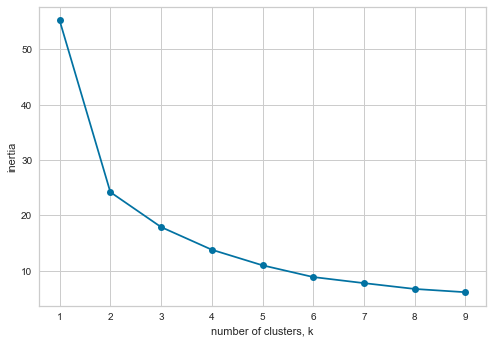

In [99]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cluster.KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(olist_scaled[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

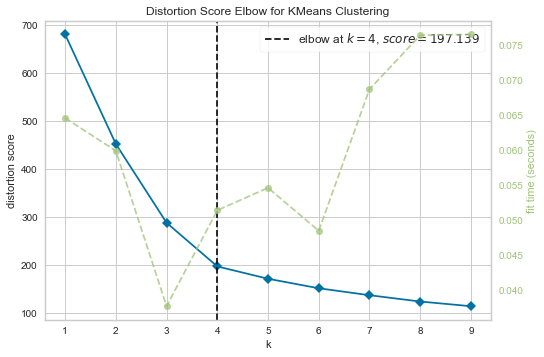

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
from yellowbrick.cluster import KElbowVisualizer

from sklearn.datasets import make_blobs

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(olist_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [102]:
myclust = MiniBatchKMeans(n_clusters=4)
myclust.fit(olist_scaled)

print(myclust.score(olist_scaled))

print(silhouette_score(olist_scaled, myclust.labels_))
print(adjusted_rand_score(y, myclust.labels_))



-198.680778313434
0.42603040996523606
0.012886305730639983


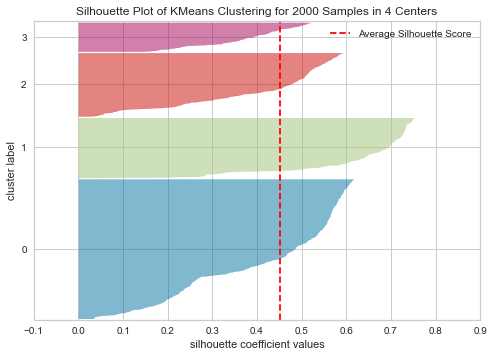

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [103]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(olist_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


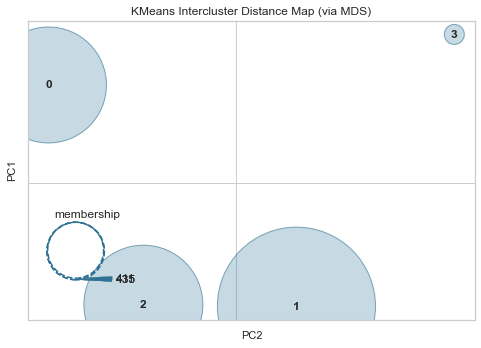

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [125]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(olist_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Apply PCA

[0.36799702 0.27255893 0.23310054 0.04648888 0.02432211 0.01647156
 0.01305667 0.0088865  0.00776061 0.00663985 0.00225457 0.00046277]
0.9999999999999998


([<matplotlib.axis.XTick at 0x14cc94940>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

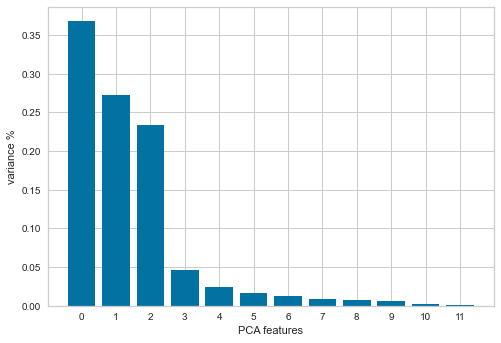

In [104]:
from sklearn import decomposition
pca = decomposition.PCA(svd_solver='full')
pca.fit(olist_scaled)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# projeter X sur les composantes principales
olist_projected = pd.DataFrame(pca.transform(olist_scaled))

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


Text(0, 0.5, 'PCA 2')

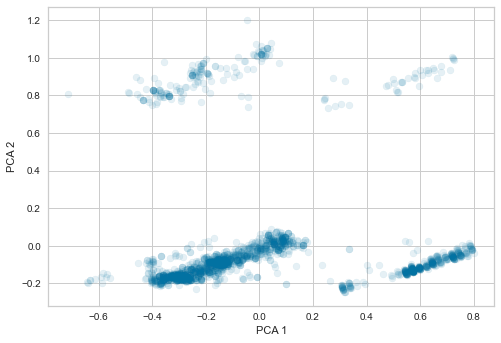

In [106]:
plt.scatter(olist_projected[0], olist_projected[1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0, 0.5, 'PCA 3')

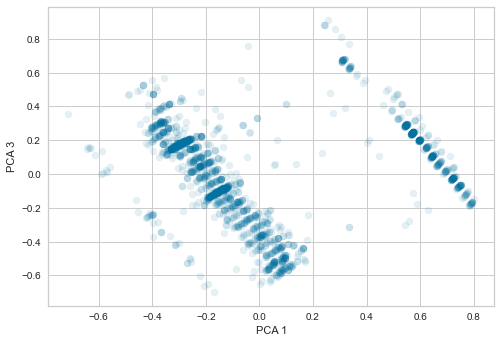

In [107]:
plt.scatter(olist_projected[0], olist_projected[2], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 3')

Text(0, 0.5, 'PCA 3')

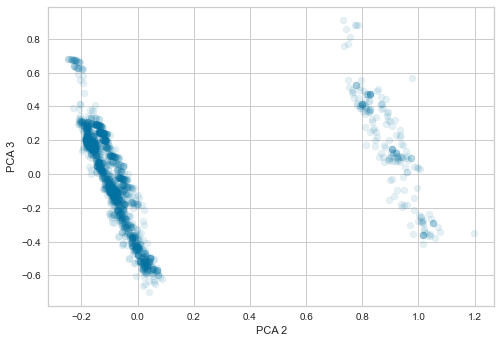

In [108]:
plt.scatter(olist_projected[1], olist_projected[2], alpha=.1)
plt.xlabel('PCA 2')
plt.ylabel('PCA 3')

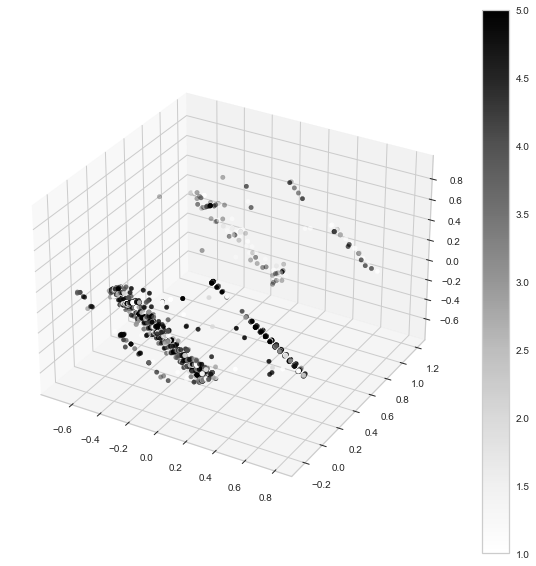

In [109]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

p = ax.scatter3D(olist_projected[0], olist_projected[1], olist_projected[2], c=y)
fig.colorbar(p)

### Kmeans Refined

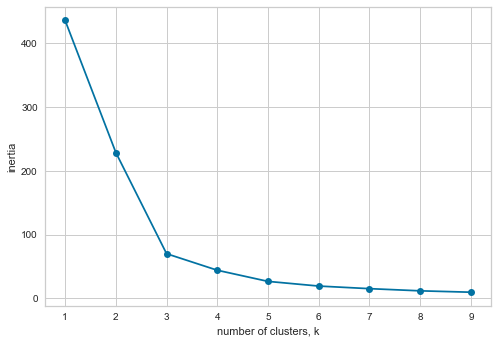

In [124]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cluster.KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(olist_projected.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

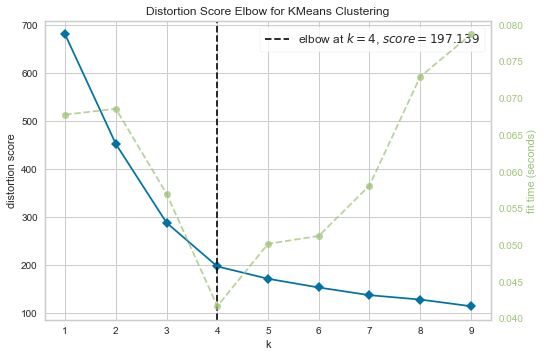

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [123]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(olist_projected)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [121]:


myclust = cluster.KMeans(n_clusters=4)
myclust.fit(olist_projected)

print(myclust.score(olist_projected))

print(silhouette_score(olist_projected, myclust.labels_))
print(adjusted_rand_score(y, myclust.labels_))
print(davies_bouldin_score(olist_projected, myclust.labels_))

-197.13897004417868
0.4522360434658361
0.013014836216071263
0.7999055649643212


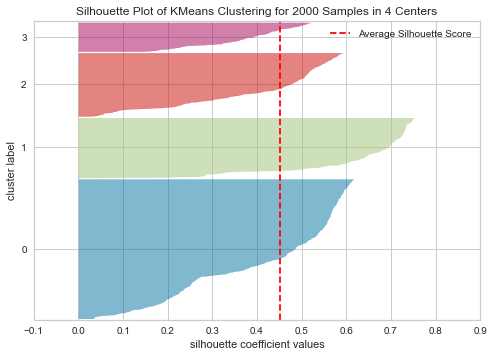

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [122]:

model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(olist_projected)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


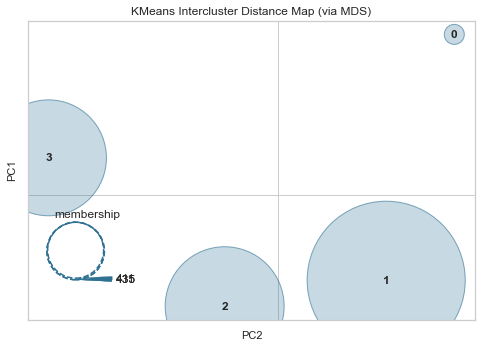

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [126]:
# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(olist_projected)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [114]:
#  todo example: https://www.kaggle.com/michaelfumery/e-commerce-customers-segmentation/notebook

In [132]:
kmeans_labels = model.labels_

olist_light['cluster_label'] = kmeans_labels

/var/folders/67/g0ptj0k1085cbm9b06vntptw0000gn/T/ipykernel_44481/4229935985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olist_light['cluster_label'] = kmeans_labels


In [133]:
olist_light.groupby('cluster_label').mean().reset_index()

,cluster_label,price,freight_value,review_score,product_category_name,payment_approval_delay,carrier_shipping_delay,delivery_estimation_precision,review_delay_after_delivery,review_delay_after_purchase,review_made_before_delivery
0,0,132.800657,35.743687,2.469697,46.590909,0.383838,26.217172,5.025253,-9.489899,29.237374,1.0
1,1,141.114498,32.866328,3.468619,55.112971,0.350418,6.350418,-13.581590,0.167364,18.804393,0.0
2,2,143.227839,47.387103,3.524138,55.560920,0.349425,11.227586,-15.181609,0.025287,22.997701,0.0
3,3,89.556642,16.917324,4.024331,13.046229,0.270073,9.260341,-11.437956,0.128954,12.472019,0.0
